In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:

# Define dataset paths inside Google Drive
train_data_dir = "/content/drive/MyDrive/Brain_Tumor_Dataset/Training"
test_data_dir = "/content/drive/MyDrive/Brain_Tumor_Dataset/Testing"

# Verify dataset exists
assert os.path.exists(train_data_dir), "❌ Training directory not found!"
assert os.path.exists(test_data_dir), "❌ Testing directory not found!"

print("✅ Dataset found and ready to use!")


✅ Dataset found and ready to use!


In [14]:
# Import system libs
import os
import itertools

# Import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Import Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# ✅ Check CUDA availability
print("✅ TensorFlow Built with CUDA:", tf.test.is_built_with_cuda())
print("✅ GPU Available:", tf.config.list_physical_devices('GPU'))

# ✅ Force TensorFlow to use GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU is set for TensorFlow! 🚀")
    except RuntimeError as e:
        print(e)


✅ TensorFlow Built with CUDA: True
✅ GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU is set for TensorFlow! 🚀


In [15]:
# Load Training Data
filepaths, labels = [], []
folders = os.listdir(train_data_dir)

for folder in folders:
    folder_path = os.path.join(train_data_dir, folder)

    # ✅ Ignore non-directory files like .DS_Store
    if not os.path.isdir(folder_path):
        continue

    files = os.listdir(folder_path)
    for file in files:
        filepaths.append(os.path.join(folder_path, file))
        labels.append(folder)

# Create DataFrame
train_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
print("✅ Training Data Loaded")


✅ Training Data Loaded


In [16]:
# Load Testing Data
filepaths, labels = [], []
folders = os.listdir(test_data_dir)

for folder in folders:
    folder_path = os.path.join(test_data_dir, folder)

    if not os.path.isdir(folder_path):
        continue

    files = os.listdir(folder_path)
    for file in files:
        filepaths.append(os.path.join(folder_path, file))
        labels.append(folder)

# Create DataFrame
test_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
print("✅ Testing Data Loaded")


✅ Testing Data Loaded


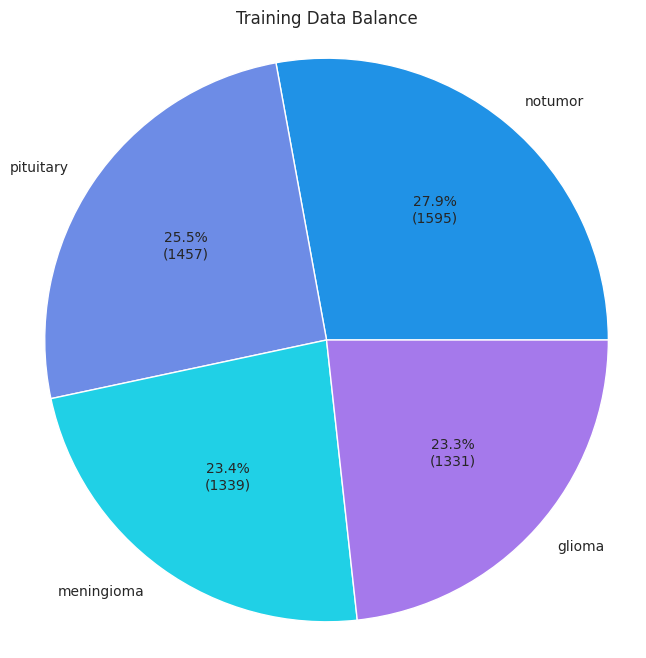

In [17]:
data_balance = train_df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.figure(figsize=(8, 8))
plt.pie(data_balance, labels=data_balance.index, autopct=custom_autopct, colors=["#2092E6","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training Data Balance")
plt.axis("equal")
plt.show()


In [18]:
valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)


In [19]:
# Reduce batch size to prevent memory crash
batch_size = 8  # Adjusted from 16 to 8 for Colab stability
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)


Found 5722 validated image filenames belonging to 4 classes.
Found 660 validated image filenames belonging to 4 classes.
Found 661 validated image filenames belonging to 4 classes.


In [20]:
img_shape = (224, 224, 3)
class_count = len(train_gen.class_indices)

# Define CNN Model
model = Sequential([
    Conv2D(32, (3,3), padding="same", activation="relu", input_shape=img_shape),
    MaxPooling2D(),
    Conv2D(64, (3,3), padding="same", activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(class_count, activation="softmax")
])

# Compile Model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train on GPU
with tf.device('/GPU:0'):
    history = model.fit(train_gen, epochs=10, validation_data=valid_gen)


Epoch 1/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 1700s 2s/step - accuracy: 0.7242 - loss: 17.6179 - val_accuracy: 0.8818 - val_loss: 0.3326
Epoch 2/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.9617 - loss: 0.1242 - val_accuracy: 0.9106 - val_loss: 0.3604
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9900 - loss: 0.0426 - val_accuracy: 0.9439 - val_loss: 0.2740
Epoch 4/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.9961 - loss: 0.0161 - val_accuracy: 0.9455 - val_loss: 0.2307
Epoch 5/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.9972 - loss: 0.0128 - val_accuracy: 0.9470 - val_loss: 0.3171
Epoch 6/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.9972 - loss: 0.0119 - val_accuracy: 0.9303 - val_loss: 0.4186
Epoch 7/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.9974 - loss: 0.0108 - val_accuracy: 0.9515 - val_loss: 0.2777
Epoch 8/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 1.0000 - loss: 4.2685e-

In [21]:
checkpoint_path = "/content/drive/MyDrive/Brain_Tumor_Dataset/best_model.keras"

# Save best model checkpoint
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

with tf.device('/GPU:0'):
    history = model.fit(train_gen, epochs=10, validation_data=valid_gen, callbacks=[checkpoint])


Epoch 1/10
715/716 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 2.0366e-05
Epoch 1: val_loss improved from inf to 0.37387, saving model to /content/drive/MyDrive/Brain_Tumor_Dataset/best_model.keras
716/716 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 1.0000 - loss: 2.0361e-05 - val_accuracy: 0.9530 - val_loss: 0.3739
Epoch 2/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 7.8413e-06
Epoch 2: val_loss did not improve from 0.37387
716/716 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 1.0000 - loss: 7.8403e-06 - val_accuracy: 0.9545 - val_loss: 0.3994
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 3.6948e-06
Epoch 3: val_loss did not improve from 0.37387
716/716 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 1.0000 - loss: 3.6947e-06 - val_accuracy: 0.9561 - val_loss: 0.3942
Epoch 4/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 1.6662e-06
Epoch 4: val_loss did not improve from 0.37387
71

In [22]:
# Load best model
best_model = keras.models.load_model(checkpoint_path)

with tf.device('/GPU:0'):
    test_score = best_model.evaluate(test_gen, verbose=1)

print("Best Model Test Loss: ", test_score[0])
print("Best Model Test Accuracy: ", test_score[1])


83/83 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9588 - loss: 0.2777
Best Model Test Loss:  0.3553580641746521
Best Model Test Accuracy:  0.9576399326324463
